In [3]:
import numpy as np
import matplotlib.pyplot as plt


In [65]:
from numba import jit
import numpy as np


@jit(nopython=True)
def mandelbroth(real, imaginary, max_iter):

    c = complex(real, imaginary)
    z = 0.0j
    
    for i in range(max_iter):
        z = z * z + c
        if np.abs(z) >= 2:
            return i
        
    return max_iter



@jit(nopython=True)
def mandelbrot_set(real, imaginary, max_iter=100):

    mandelbrot = np.zeros((len(real), len(imaginary)), dtype=np.int64)

    for i in range(len(real)):
        if i % 100 == 0:
            print(f"i={i/3000*100}")
        for j in range(len(imaginary)):
            mandelbrot[i, j] = mandelbroth(real[i], imaginary[j], max_iter)

    return mandelbrot


i=<object type:float64>
i=<object type:float64>
i=<object type:float64>
i=<object type:float64>
i=<object type:float64>
i=<object type:float64>
i=<object type:float64>
i=<object type:float64>
i=<object type:float64>
i=<object type:float64>
i=<object type:float64>
i=<object type:float64>
i=<object type:float64>
i=<object type:float64>
i=<object type:float64>
i=<object type:float64>
i=<object type:float64>
i=<object type:float64>
i=<object type:float64>
i=<object type:float64>
i=<object type:float64>
i=<object type:float64>
i=<object type:float64>
i=<object type:float64>
i=<object type:float64>
i=<object type:float64>
i=<object type:float64>
i=<object type:float64>
i=<object type:float64>
i=<object type:float64>


KeyboardInterrupt: 

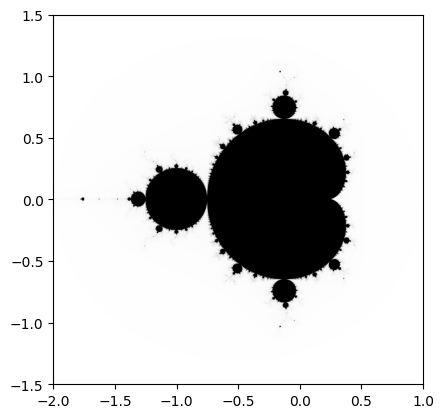

In [66]:
real = np.linspace (-2,1,3000)
imaginary = np.linspace (-1.5,1.5,3000)

# creates a 2D array of the mandelbrot set 
mandelbrot = mandelbrot_set(real, imaginary, max_iter=500).T

plt.imshow(mandelbrot, extent = [-2,1,-1.5,1.5], cmap='binary')
plt.savefig("Fractal.png",dpi= 2000)
plt.show()

0
0
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225


c:\Users\ezrad\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ezrad\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475


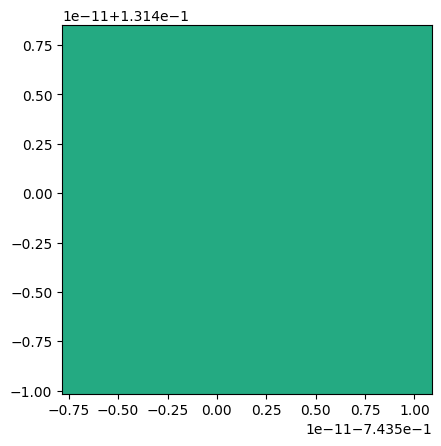

In [58]:
from matplotlib.animation import FuncAnimation

# Create initial plot
fig, ax = plt.subplots()

real_values = np.linspace(-2, 1, 1500)
imaginary_values = np.linspace(-1.5, 1.5, 1500)
mandelbrot = mandelbrot_set(real_values, imaginary_values)

im = ax.imshow(mandelbrot.T, extent=[-2, 1, -1.5, 1.5], animated=True)

def find_edge_coordinates(mandelbrot_set):
    
    edge_coords = np.argwhere(mandelbrot_set[:-1, :-1] != mandelbrot_set[1:, 1:])
    return edge_coords

def update(frame):
    global real_values, imaginary_values
    print(frame)
    mandelbrot = mandelbrot_set(real_values, imaginary_values, max_iter=500)
    edge_coords = find_edge_coordinates(mandelbrot)

    if len(edge_coords) == 0:
        return

    edge_x, edge_y = np.mean(edge_coords, axis=0)
    
    center_real = real_values[int(edge_x)]
    center_imag = imaginary_values[int(edge_y)]

    zoom_factor = 0.95

    real_values = real_values * zoom_factor + (1 - zoom_factor) * center_real
    imaginary_values = imaginary_values * zoom_factor + (1 - zoom_factor) * center_imag

    # Recalculate Mandelbrot set and update plot
    mandelbrot = mandelbrot_set(real_values, imaginary_values)
    im.set_array(mandelbrot.T)
    im.set_extent([real_values[0], real_values[-1], imaginary_values[0], imaginary_values[-1]])

    return [im]

# Create animation
ani = FuncAnimation(fig, update, frames=500, blit=True)
ani.save('mandel_zoom.gif', writer='pillow', fps=30)
plt.show()


In [60]:
def monte_carlo(samples, array):

    array_size = array.shape[0]

    # we can recognize the max iterations since it will be the max in array
    max_iter = np.max(array)  
    total_area = 3 * 3  # (1 - (-2)) * (1.5 - (-1.5))
    x = np.random.randint(0, array_size, size=samples)
    y = np.random.randint(0, array_size, size=samples)
    
    inside = np.sum(array[x, y] == max_iter)
    
    return (inside / samples) * total_area

print("The area of the mandelbrot set is approximately", monte_carlo(10_000_000,mandelbrot))


The area of the mandelbrot set is approximately 1.5410861999999999


In [43]:
real_values = np.linspace(-2, 1, 2000)
imaginary_values = np.linspace(-1.5, 1.5, 2000)

iterations = np.linspace(10,1000,20, dtype=int)  # From 10^0=1 to 10^3=1000, 50 points
samples = np.logspace(2, 7, 20, dtype=int)  # From 10^2=100 to 10^6=1,000,000, 50 points

# Initialize the areas array to be of shape (len(iterations), len(samples))
areas = np.zeros((len(iterations), len(samples)))

# found at: https://www2.pd.infn.it/~lacaprar/Didattica/C++/Complex/Area%20of%20the%20Mandelbrot%20Set.pdf
A_m_theory = 1.506484
print(f"The area of the Mandelbrot set is {A_m_theory:.4f}")

for i, iter in enumerate(iterations):
    print(f"Current iteration is {iter}")
    mandelbrot_array = mandelbrot_set(real_values, imaginary_values, max_iter=iter)
    
    for j, s in enumerate(samples):
        for _ in range(15):
            area_dx = np.abs(monte_carlo(s, mandelbrot_array) - A_m_theory) / 10
            areas[i, j] += area_dx

The area of the Mandelbrot set is 1.5092
Current iteration is 10
Current iteration is 62
Current iteration is 114
Current iteration is 166
Current iteration is 218
Current iteration is 270
Current iteration is 322
Current iteration is 374
Current iteration is 426
Current iteration is 478
Current iteration is 531
Current iteration is 583
Current iteration is 635
Current iteration is 687
Current iteration is 739
Current iteration is 791
Current iteration is 843
Current iteration is 895
Current iteration is 947
Current iteration is 1000


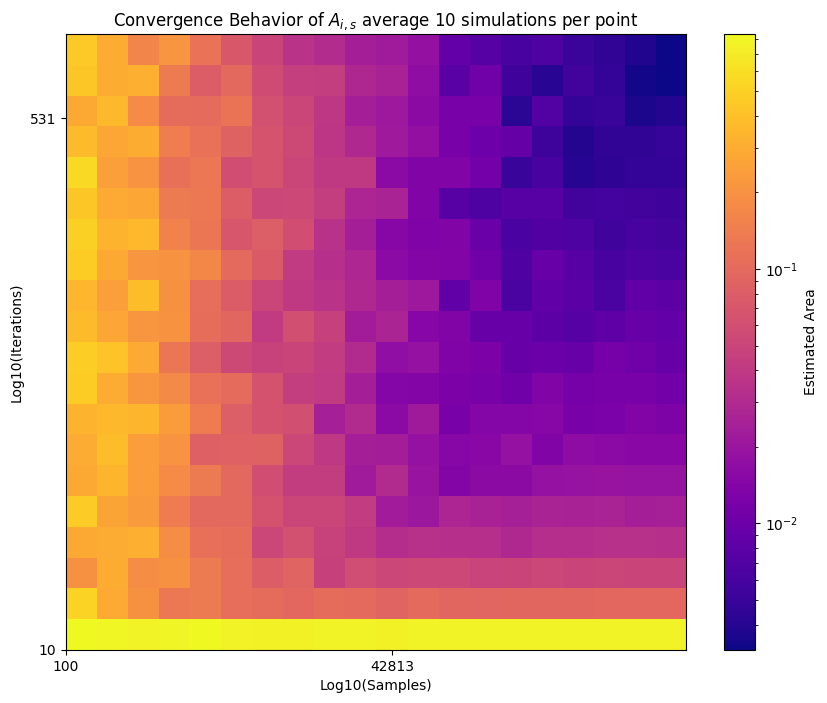

In [45]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(10, 8))
c = plt.imshow(areas, aspect='auto', cmap='plasma', origin='lower', norm=LogNorm() ,
               extent=[np.log10(samples[0]), np.log10(samples[-1]), np.log10(iterations[0]), np.log10(iterations[-1])])


plt.colorbar(label='Estimated Area')


plt.xlabel('Log10(Samples)')
plt.ylabel('Log10(Iterations)')


plt.xticks(np.log10(samples)[::10], samples[::10])
plt.yticks(np.log10(iterations)[::10], iterations[::10])

plt.title('Convergence Behavior of $A_{i,s}$ average 10 simulations per point')
plt.show()
